In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import glob
import pickle 

from collections import defaultdict, Counter

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from sklearn.feature_extraction.text import TfidfVectorizer

## Data inladen

In [2]:
recs = pd.read_csv(r'C:/Users/Roan/Documents/bachelor_scriptie/Machine Learning/predicted.csv').drop("Unnamed: 0", axis = 1)

In [3]:
recs = recs[["user", "vids_watched", "vid", "conspiracy_pred", "strategy"]]
recs.head()

,user,vids_watched,vid,conspiracy_pred,strategy
0,scriptiebot1@gmail.com,1,Jjge2pYKuUM,False,strategy 1
1,scriptiebot1@gmail.com,1,5yx6BWlEVcY,False,strategy 1
2,scriptiebot1@gmail.com,1,Bj9PLkKNF-c,False,strategy 1
3,scriptiebot1@gmail.com,1,SMNHZR1u6KQ,False,strategy 1
4,scriptiebot1@gmail.com,1,46siYNcHMxM,False,strategy 1


In [4]:
strats = recs[["user", "strategy"]].drop_duplicates()

In [5]:
path = r'C:/Users/Roan/Documents/bachelor_scriptie/Results/experiment 1'

all_files = glob.glob(path + "/strat_*/watched*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=0, header=0)
    li.append(df)

watched = pd.concat(li, axis=0, ignore_index=True)

In [6]:
watched = pd.merge(watched, strats, left_on="user", right_on="user").drop(["views", "likes", "dislikes", "date"], axis=1)

In [7]:
watched["url"] = watched["url"].apply(lambda x: x.split("?v=")[1].split("&t=")[0])

In [8]:
watched.shape

(300, 4)

## Conspiracy tags for watched videos

In [9]:
ml_watched = pd.read_csv("watched_videos_clean.csv").drop("Unnamed: 0", axis=1)

equal = pd.read_csv("../data/training_videos.csv").drop("Unnamed: 0", axis = 1)
equal["full_text"].fillna("", inplace=True)

In [10]:
# Vectorize words
v = TfidfVectorizer(max_df=.75, min_df=2)
x = v.fit_transform(equal['full_text'])

In [11]:
svm = pickle.load(open('../Machine Learning/SVM_trained.sav', 'rb'))
predictions = svm.predict(v.transform(ml_watched["full_text"].values))

In [12]:
conspiracy = [False] * 75

conspiracy.extend([True] * 75)

conspiracy.extend(predictions[150:])

len(conspiracy)

300

In [13]:
watched["conspiracy"] = conspiracy
watched.tail()

,user,video_number,url,strategy,conspiracy
295,scriptiebot20a@gmail.com,11,Ig0GA2qeIAE,strategy 4,True
296,scriptiebot20a@gmail.com,12,x3bJTARZUWc,strategy 4,True
297,scriptiebot20a@gmail.com,13,x3bJTARZUWc,strategy 4,True
298,scriptiebot20a@gmail.com,14,bSDfdzTKm2c,strategy 4,True
299,scriptiebot20a@gmail.com,15,a8z2Y1gwefU,strategy 4,True


In [14]:
# watched.query("strategy == 'strategy 4'")
recs["vid"] = recs["vid"].apply(lambda x: x.split("&t=")[0])


## Create network

In [15]:
graphs = {"strategy 1" : nx.DiGraph(), "strategy 2" : nx.DiGraph(), 
          "strategy 3" : nx.DiGraph(), "strategy 4" : nx.DiGraph()}

for strat in graphs:
    for i in watched.query("strategy == @strat").itertuples():
        # User, vid number, url
        u, n, url, strategy, conspiracy = i[1:]
        
        # Find recommendations from current video
        p = recs.query("(user == @u) & (vids_watched == @n)")
                
        # Set seed node
        graphs[strat].add_node(url, vid_type = 2, conspiracy = conspiracy)
            
        # Add recommendations and their types
        graphs[strat].add_nodes_from([x[3] for x in p.itertuples()
                                      if x[-2] and x[3] not in graphs[strat]], 
                                      vid_type = 3, 
                                      conspiracy = True)
        
        graphs[strat].add_nodes_from([x[3] for x in p.itertuples() 
                                      if not x[-2] and x[3] not in graphs[strat]], 
                                      vid_type = 1, 
                                      conspiracy = False)
            
        # Add edges
        graphs[strat].add_edges_from([(url, x[3]) for x in p.itertuples()])

In [16]:
colors = defaultdict(list)

# Determine colors of nodes
for strat in graphs:
    for n in graphs[strat]:
        conspiracy = graphs[strat].nodes[n]["conspiracy"]
        if conspiracy: # conspiracy
            colors[strat].append("#f54242")
        else: # conspiracy
            colors[strat].append("#4287f5")

In [30]:
def curver(graphs, strat):
    pos = {}
    new = []
    x = []
    
    if strat != "strategy 1":
        smoothing = 0.00000005
    else:
        smoothing = 0.0000000125

    for k, v in nx.multipartite_layout(graphs[strat], subset_key = "vid_type").items():
        x.append(v[0])

    dist = Counter(x)
    seeds = set(x)
    left, seed, right = sorted(list(seeds))

    for k, v in dist.items():
        if k != seed:
            if k == left:
                for i in range(v):
                    new.append(k + (abs(v//2 - i))**2 * smoothing)
            elif k == right:
                for i in range(v):
                    new.append(k - (abs(v//2 - i))**2 * smoothing)
        else:
            new.extend([k] * v)

    for i, dic in enumerate(nx.multipartite_layout(graphs[strat], subset_key = "vid_type").items()):
        pos[dic[0]] = np.array([new[i], dic[1][1]])

    return pos

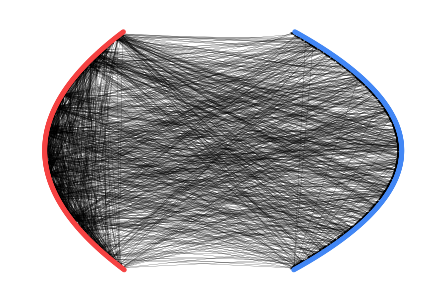

In [31]:
nx.draw(graphs["strategy 4"], 
        pos = curver(graphs, "strategy 4"),
        node_color = colors["strategy 4"],
        node_size = 15,
        width = 0.2,
        arrowsize = 5)

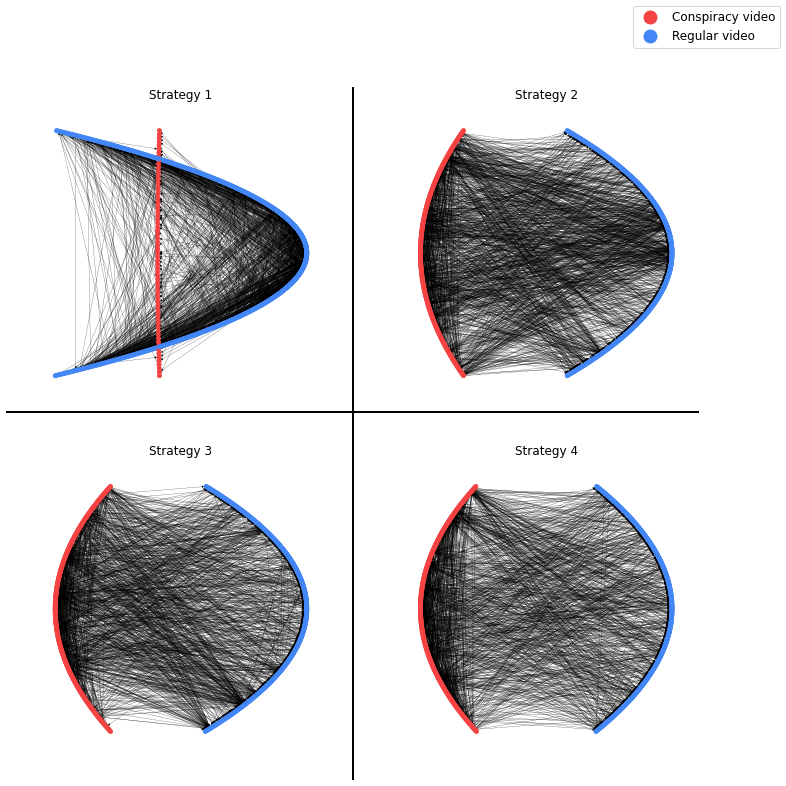

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax = axes.flatten()

# Plot the different graphs (this may take a while)
for i, strat in enumerate(colors.keys()):
    nx.draw(graphs[strat], 
            pos = curver(graphs, strat),
            node_color = colors[strat], 
            ax = ax[i],
            node_size = 15,
            width = 0.2,
            arrowsize = 5) 
    
    ax[i].set_title(strat.capitalize())
       
# Dividers between plots
ax[3].plot([0.5, 0.5], [0.1, 0.9], color='black', lw=2,
         transform=plt.gcf().transFigure, clip_on=False);
ax[3].plot([0.1, 0.9], [0.525, 0.525], color='black', lw=2,
         transform=plt.gcf().transFigure, clip_on=False);

# Title and legend
# fig.suptitle('The recommendation network of each strategy', fontsize = 16);
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Conspiracy video',
                          markerfacecolor='#f54242', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Regular video',
                          markerfacecolor='#4287f5', markersize=15)]

fig.legend(handles=legend_elements, fontsize=12);
plt.savefig('recommendation_networks.pdf');

## Analyse network

In [87]:
metrics = defaultdict(list)

# Find metrics for each network
for strat in graphs:
    metrics["betweenness_centrality"].append(np.mean(list(nx.betweenness_centrality(graphs[strat]).values())))
    metrics["clustering_coefficient"].append(nx.average_clustering(graphs[strat]))
    
    metrics["density"].append(nx.density(graphs[strat]))
    metrics["size"].append(graphs[strat].size() / (15 * 5 * 20))
    
    metrics["SCC"].append(len(max(list(nx.strongly_connected_components(graphs[strat])), key=len)))
    
    try:
        metrics["avg path length"].append(nx.average_shortest_path_length(graphs[strat].to_undirected()))
    except:
        metrics["avg path length"].append(np.nan)
        
    try:
        metrics["diameter"].append(nx.diameter(graphs[strat].to_undirected()))
    except Exception as e:
        metrics["diameter"].append(np.nan)
    
metrics = pd.DataFrame(metrics, index=graphs.keys())

In [88]:
print(metrics[["betweenness_centrality", "clustering_coefficient"]].to_latex())

\begin{tabular}{lrr}
\toprule
{} &  betweenness\_centrality &  clustering\_coefficient \\
\midrule
strategy 1 &            1.597418e-07 &                0.001592 \\
strategy 2 &            0.000000e+00 &                0.000000 \\
strategy 3 &            2.198488e-06 &                0.009512 \\
strategy 4 &            1.136934e-04 &                0.039018 \\
\bottomrule
\end{tabular}



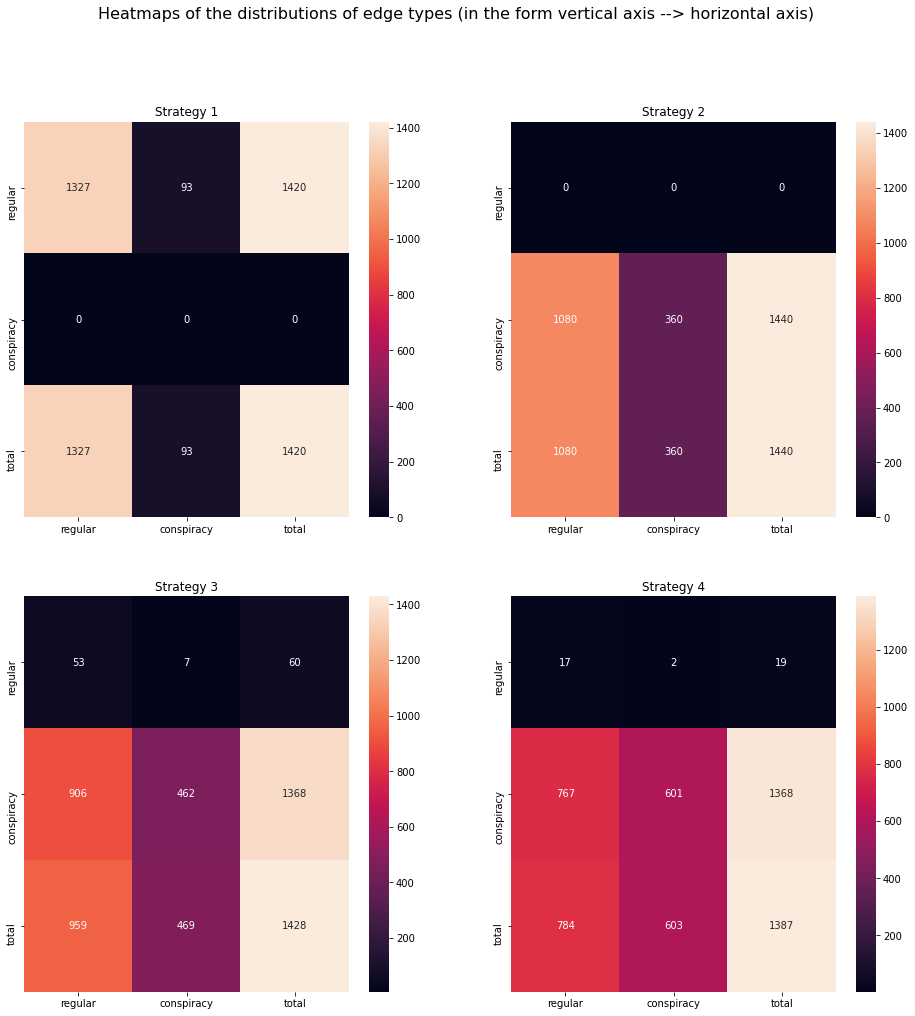

In [89]:
vid_types = {0 : "regular", 1 : "conspiracy"}
counts = defaultdict(lambda: defaultdict(int))

heatmaps = []

for strat in graphs:
    for edge in graphs[strat].edges():
        # Find vid type of both nodes of the edge
        A = graphs[strat].nodes[edge[0]]["conspiracy"]
        B = graphs[strat].nodes[edge[1]]["conspiracy"]
        
        # Convert the number to a string
        A = vid_types[A]
        B = vid_types[B]
        
        # Increase the count of the current strat
        counts[strat][(A, B)] += 1
    
    # Layout of the DataFrame
    mat = pd.DataFrame(index = ["regular", "conspiracy"], columns = ["regular", "conspiracy"])
    
    # Add distribution of connection types
    for k, v in counts[strat].items():
        mat.loc[k[0]][k[1]] = v
        
    # Calculate totals
    mat["total"] = mat.sum(axis = 1)
    mat.loc["total"] = mat.sum()
        
    # Fill na with zeroes and convert to integers
    heatmaps.append(mat.fillna(0).astype(int))
    
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 16));
    
for i in range(len(heatmaps)):
    sns.heatmap(heatmaps[i], annot=True, ax=axes.flat[i], fmt='g');
    axes.flat[i].set_title(f"Strategy {i + 1}")

    
fig.suptitle('Heatmaps of the distributions of edge types (in the form vertical axis --> horizontal axis)', fontsize = 16);

In [90]:
pcrs = []
prcs = []
pccs = []
prrs = []

for t in heatmaps:
    # P(C|R) --> Conditional probability of an edge going to C if it starts in R
    pcr = t.loc["regular"]["conspiracy"] / t.loc["regular"]["total"]

    # P(R|R) --> Conditional probability of an edge going to R if it starts in R
    prr = t.loc["regular"]["regular"] / t.loc["regular"]["total"]
 

    # P(R|C) --> Conditional probability of an edge going to R if it starts in C
    prc = t.loc["conspiracy"]["regular"] / t.loc["conspiracy"]["total"]
    
    # P(C|C) --> Conditional probability of an edge going to C if it starts in C
    pcc = t.loc["conspiracy"]["conspiracy"] / t.loc["conspiracy"]["total"]
    
    
    pcrs.append(pcr)
    prcs.append(prc)
    pccs.append(pcc)
    prrs.append(prr)
    
table = pd.DataFrame(index = ["Strategy 1", "Strategy 2", "Strategy 3", "Strategy 4"], 
                     columns = ["P(C|R)", "P(R|C)", "P(C|C)", "P(R|R)"])

table["P(C|R)"] = pcrs
table["P(R|C)"] = prcs
table["P(C|C)"] = pccs
table["P(R|R)"] = prrs


print(table.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &    P(C|R) &    P(R|C) &    P(C|C) &    P(R|R) \\
\midrule
Strategy 1 &  0.065493 &       NaN &       NaN &  0.934507 \\
Strategy 2 &       NaN &  0.750000 &  0.250000 &       NaN \\
Strategy 3 &  0.116667 &  0.662281 &  0.337719 &  0.883333 \\
Strategy 4 &  0.105263 &  0.560673 &  0.439327 &  0.894737 \\
\bottomrule
\end{tabular}



D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


## Subnetwork

Here, only the conspiracy nodes are kept

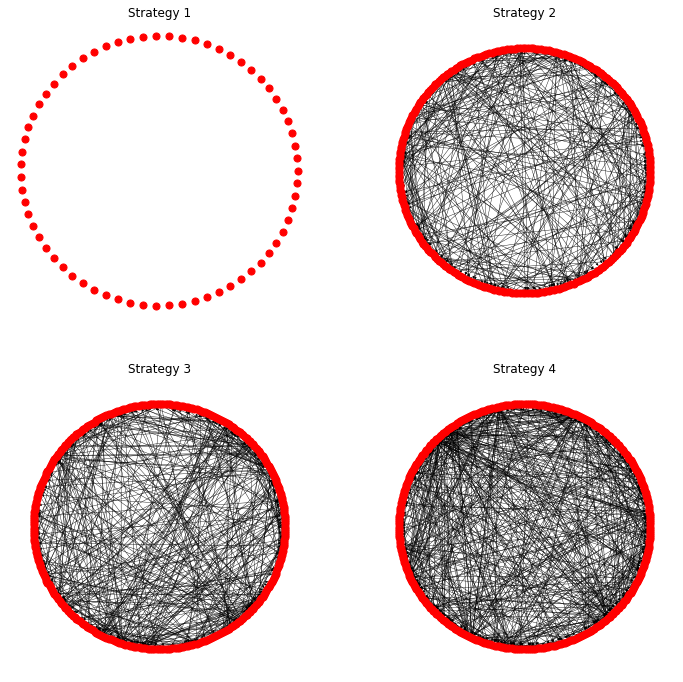

In [91]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax = axes.flatten()

metrics_2 = defaultdict(list)

for i, strat in enumerate(graphs):
    sg = nx.subgraph(graphs[strat], [x for x in graphs[strat] if graphs[strat].nodes[x]["conspiracy"]])
    nx.draw(sg, 
            node_color="red", 
            pos = nx.circular_layout(sg), 
            ax = ax[i],
            width = 0.4,
            arrowsize = 5,
            node_size = 50,
)
    
    ax[i].set_title(f"Strategy {i + 1}")
    
    metrics_2["betweenness_centrality"].append(np.mean(list(nx.betweenness_centrality(sg).values())))
    metrics_2["clustering_coefficient"].append(nx.average_clustering(sg))
    
plt.savefig('conspiracy networks.pdf');

In [92]:
metrics_2_df = pd.DataFrame(metrics_2).set_index(pd.Index(["Strategy 1", "Strategy 2", "Strategy 3", "Strategy 4"]))

In [93]:
print(metrics_2_df.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  betweenness\_centrality &  clustering\_coefficient \\
\midrule
Strategy 1 &                0.000000 &                0.000000 \\
Strategy 2 &                0.000000 &                0.000000 \\
Strategy 3 &                0.000014 &                0.016783 \\
Strategy 4 &                0.000747 &                0.058816 \\
\bottomrule
\end{tabular}

